In [1]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
import sklearn
import imblearn
import sys

# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

# Settings
pd.set_option('display.max_columns', None)
np.set_printoptions(threshold=sys.maxsize)
np.set_printoptions(precision=3)
sns.set(style="darkgrid")
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

In [2]:
train = pd.read_csv("/content/Train_data.csv")
test = pd.read_csv("/content/Test_data.csv")

In [3]:
print(train.head(4))

print("Training data has {} rows & {} columns".format(train.shape[0],train.shape[1]))

   duration protocol_type   service flag  src_bytes  dst_bytes  land  \
0         0           tcp  ftp_data   SF        491          0     0   
1         0           udp     other   SF        146          0     0   
2         0           tcp   private   S0          0          0     0   
3         0           tcp      http   SF        232       8153     0   

   wrong_fragment  urgent  hot  num_failed_logins  logged_in  num_compromised  \
0               0       0    0                  0          0                0   
1               0       0    0                  0          0                0   
2               0       0    0                  0          0                0   
3               0       0    0                  0          1                0   

   root_shell  su_attempted  num_root  num_file_creations  num_shells  \
0           0             0         0                   0           0   
1           0             0         0                   0           0   
2           0 

In [4]:
print(test.head(4))

print("Testing data has {} rows & {} columns".format(test.shape[0],test.shape[1]))

   duration protocol_type   service flag  src_bytes  dst_bytes  land  \
0         0           tcp   private  REJ          0          0     0   
1         0           tcp   private  REJ          0          0     0   
2         2           tcp  ftp_data   SF      12983          0     0   
3         0          icmp     eco_i   SF         20          0     0   

   wrong_fragment  urgent  hot  num_failed_logins  logged_in  num_compromised  \
0               0       0    0                  0          0                0   
1               0       0    0                  0          0                0   
2               0       0    0                  0          0                0   
3               0       0    0                  0          0                0   

   root_shell  su_attempted  num_root  num_file_creations  num_shells  \
0           0             0         0                   0           0   
1           0             0         0                   0           0   
2           0 

In [5]:
#'num_outbound_cmds' is a redundant column so remove it from both train & test datasets
train.drop(['num_outbound_cmds'], axis=1, inplace=True)
test.drop(['num_outbound_cmds'], axis=1, inplace=True)

In [6]:
# Attack Class Distribution
train['class'].value_counts()

normal     13449
anomaly    11743
Name: class, dtype: int64

In [7]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

# extract numerical attributes and scale it to have zero mean and unit variance
cols = train.select_dtypes(include=['float64','int64']).columns
sc_train = scaler.fit_transform(train.select_dtypes(include=['float64','int64']))
sc_test = scaler.fit_transform(test.select_dtypes(include=['float64','int64']))

# turn the result back to a dataframe
sc_traindf = pd.DataFrame(sc_train, columns = cols)
sc_testdf = pd.DataFrame(sc_test, columns = cols)

In [8]:
from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()

# extract categorical attributes from both training and test sets
cattrain = train.select_dtypes(include=['object']).copy()
cattest = test.select_dtypes(include=['object']).copy()

# encode the categorical attributes
traincat = cattrain.apply(encoder.fit_transform)
testcat = cattest.apply(encoder.fit_transform)

# separate target column from encoded data
enctrain = traincat.drop(['class'], axis=1)
cat_Ytrain = traincat[['class']].copy()


In [9]:
train_x = pd.concat([sc_traindf,enctrain],axis=1)
train_y = train['class']
train_x.shape

(25192, 40)

In [10]:
test_df = pd.concat([sc_testdf,testcat],axis=1)
test_df.shape

(22544, 40)

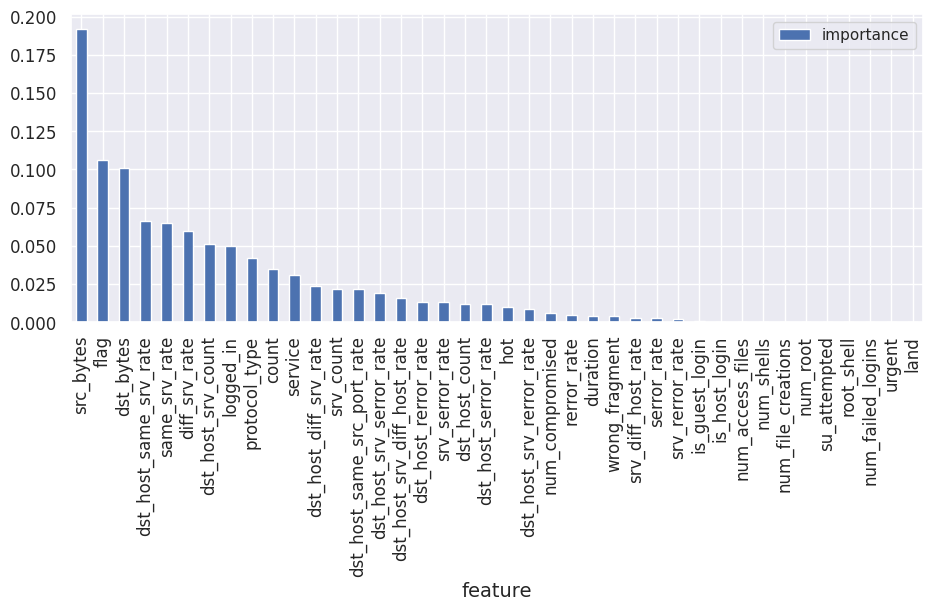

In [11]:
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier();

# fit random forest classifier on the training set
rfc.fit(train_x, train_y);
# extract important features
score = np.round(rfc.feature_importances_,3)
importances = pd.DataFrame({'feature':train_x.columns,'importance':score})
importances = importances.sort_values('importance',ascending=False).set_index('feature')
# plot importances
plt.rcParams['figure.figsize'] = (11, 4)
importances.plot.bar();

In [12]:
from sklearn.feature_selection import RFE
import itertools
rfc = RandomForestClassifier()

# create the RFE model and select 10 attributes
rfe = RFE(rfc, n_features_to_select=15)
rfe = rfe.fit(train_x, train_y)

# summarize the selection of the attributes
feature_map = [(i, v) for i, v in itertools.zip_longest(rfe.get_support(), train_x.columns)]
selected_features = [v for i, v in feature_map if i==True]

selected_features


['src_bytes',
 'dst_bytes',
 'logged_in',
 'count',
 'srv_count',
 'same_srv_rate',
 'diff_srv_rate',
 'dst_host_srv_count',
 'dst_host_same_srv_rate',
 'dst_host_diff_srv_rate',
 'dst_host_same_src_port_rate',
 'dst_host_srv_diff_host_rate',
 'protocol_type',
 'service',
 'flag']

In [13]:
from sklearn.model_selection import train_test_split

X_train,X_test,Y_train,Y_test = train_test_split(train_x,train_y,train_size=0.70, random_state=20)

In [14]:
from sklearn.svm import SVC
from sklearn.naive_bayes import BernoulliNB
from sklearn import tree
from sklearn.model_selection import cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression

# Train KNeighborsClassifier Model
KNN_Classifier = KNeighborsClassifier(n_jobs=-1)
KNN_Classifier.fit(X_train, Y_train);

# Train LogisticRegression Model
LGR_Classifier = LogisticRegression(n_jobs=-1, random_state=0)
LGR_Classifier.fit(X_train, Y_train);

# Train Gaussian Naive Baye Model
BNB_Classifier = BernoulliNB()
BNB_Classifier.fit(X_train, Y_train)

# Train Decision Tree Model
DTC_Classifier = tree.DecisionTreeClassifier(criterion='entropy', random_state=0)
DTC_Classifier.fit(X_train, Y_train)


DecisionTreeClassifier(criterion='entropy', random_state=0)

In [15]:
from sklearn import metrics

models = []
models.append(('Naive Baye Classifier', BNB_Classifier))
models.append(('Decision Tree Classifier', DTC_Classifier))
models.append(('KNeighborsClassifier', KNN_Classifier))
models.append(('LogisticRegression', LGR_Classifier))

for i, v in models:
    scores = cross_val_score(v, X_train, Y_train, cv=10)
    accuracy = metrics.accuracy_score(Y_train, v.predict(X_train))
    confusion_matrix = metrics.confusion_matrix(Y_train, v.predict(X_train))
    classification = metrics.classification_report(Y_train, v.predict(X_train))
    print()
    print('============================== {} Model Evaluation =============================='.format(i))
    print()
    print ("Cross Validation Mean Score:" "\n", scores.mean())
    print()
    print ("Model Accuracy:" "\n", accuracy)
    print()
    print("Confusion matrix:" "\n", confusion_matrix)
    print()
    print("Classification report:" "\n", classification)
    print()


============================== Naive Baye Classifier Model Evaluation ==============================

Cross Validation Mean Score:
 0.9061471762083544

Model Accuracy:
 0.9062039242372689

Confusion matrix:
 [[6998 1271]
 [ 383 8982]]

Classification report:
               precision    recall  f1-score   support

     anomaly       0.95      0.85      0.89      8269
      normal       0.88      0.96      0.92      9365

    accuracy                           0.91     17634
   macro avg       0.91      0.90      0.91     17634
weighted avg       0.91      0.91      0.91     17634



============================== Decision Tree Classifier Model Evaluation ==============================

Cross Validation Mean Score:
 0.9953500591009707

Model Accuracy:
 1.0

Confusion matrix:
 [[8269    0]
 [   0 9365]]

Classification report:
               precision    recall  f1-score   support

     anomaly       1.00      1.00      1.00      8269
      normal       1.00      1.00      1.00      9365

In [16]:
RF_Classifier = RandomForestClassifier( random_state=0)
RF_Classified=RF_Classifier.fit(X_train, Y_train);

In [17]:

scores = cross_val_score(RF_Classified, X_train, Y_train, cv=10)
accuracy = metrics.accuracy_score(Y_train, RF_Classified.predict(X_train))
confusion_matrix = metrics.confusion_matrix(Y_train, RF_Classified.predict(X_train))
classification = metrics.classification_report(Y_train, RF_Classified.predict(X_train))

In [18]:

print()
print ("Cross Validation Mean Score:" "\n", scores.mean())
print()
print ("Model Accuracy:" "\n", accuracy)
print()
print("Confusion matrix:" "\n", confusion_matrix)
print()
print("Classification report:" "\n", classification)
print()


Cross Validation Mean Score:
 0.9973914542182916

Model Accuracy:
 1.0

Confusion matrix:
 [[8269    0]
 [   0 9365]]

Classification report:
               precision    recall  f1-score   support

     anomaly       1.00      1.00      1.00      8269
      normal       1.00      1.00      1.00      9365

    accuracy                           1.00     17634
   macro avg       1.00      1.00      1.00     17634
weighted avg       1.00      1.00      1.00     17634


